# **Scraping de titulares de varios periódicos**

In [1]:
import urllib3

def get_request(uri):
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [2]:
from copy import deepcopy
import json

from bs4 import BeautifulSoup


with open('Media/medios.json',"r") as f:
    urls = json.load(f)


DATA=[]
claves = {}
for key,x in urls.items():
    DATA.append([key,x['url'],x['tag'],x['clase'],x['HTMLURL'],x['valueURL']])

datos=[]
for index,dato in enumerate(DATA):
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    enlaces={}
    frase=[]
    urls=[]
    for text in soup.find_all(dato[2],{"class":dato[3]} if len(dato[3])>0 else None):
        texto = text.text.replace("\n","")
        texto = texto.replace("\r","")
        texto = texto.replace("\t","")
        if dato[4] == ".":
            enlace = text
            bEnlace = text[dato[5]]
        else:
            enlace=text.findChildren(dato[4] , recursive=False)
            if len(enlace)==0:
                continue
            bEnlace = enlace[0][dato[5]]
        if bEnlace.startswith("/"):
            bEnlace=dato[1]+bEnlace
        datosenlace=[texto,bEnlace,0]
        datos.append(datosenlace)
        urls.append(bEnlace)
    claves[dato[0]]=urls


In [3]:
datos

[['Alcoa reiniciará las cubas este próximo lunes, pero avisa que así los fondos se agotarán antes',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/26/alcoa-reiniciara-cubas-proximo-lunes-avisa-fondos-agotaran/00031706261849973822404.htm',
  0],
 ['El juez García Castellón señala que Tsunami «tenía en mente» actuar contra la comitiva del rey en Barcelona en el 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0],
 ['Seis camiones que transportan palas eólicas, bloqueados en Pedrafita al no poder pasar por el viaducto de la A-6',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0],
 ['El laberinto de la selectividad: criterios diferentes por universidad y exámenes propios en cada comunidad',
  'http://www.lavoz

In [4]:
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')

stop_words = stopwords.words('spanish')

stop_words += ["\u200b", "\xa0", "para", "como", "puede","cómo", "hacer", "forma", "parte", "hace", "además", "según", "pueden", "ser","tras"]

stop_words[:10]

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [5]:
from copy import deepcopy
import re

regex = "|".join(stop_words)
frasesEditadas = deepcopy(datos)
for index,dato in enumerate(datos):
    viejaFrase=deepcopy(dato[0])
    fraseNueva = re.sub(f"\\b({regex})\\b", " ", viejaFrase)
    frasecompleta = fraseNueva.strip ()
    palabras = frasecompleta.split ()
    frasecompleta = " ".join([re.sub(r'^\W|\W$', '', p.lower()) for p in palabras if len(re.sub(r'^\W|\W$', '', p)) > 3])
    frasesEditadas[index] = [frasecompleta,frasesEditadas[index][1],frasesEditadas[index][2]]

In [6]:
frasesEditadas

[['alcoa reiniciará cubas próximo lunes avisa fondos agotarán',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/26/alcoa-reiniciara-cubas-proximo-lunes-avisa-fondos-agotaran/00031706261849973822404.htm',
  0],
 ['juez garcía castellón señala tsunami mente actuar comitiva barcelona 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0],
 ['seis camiones transportan palas eólicas bloqueados pedrafita poder pasar viaducto',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0],
 ['laberinto selectividad criterios diferentes universidad exámenes propios cada comunidad',
  'http://www.lavozdegalicia.com/noticia/selectividad/2024/01/25/laberinto-selectividad/00031706201037700746950.htm',
  0],
 ['suman escaños ourense l

In [7]:
from copy import deepcopy
import pprint

frecuencias = {}

textoEntero = " ".join([sublista[0] for sublista in frasesEditadas])
for palabra in textoEntero.split():
    palabra = palabra.strip() # Elimina los espacios al principio y al final
    if palabra in frecuencias:
        frecuencias[palabra] += 1 # Aumenta la frecuencia si la palabra ya existe
    else:
        frecuencias[palabra] = 1 # Crea una nueva entrada si la palabra no existe

for index,portadaE in enumerate(frasesEditadas):
    palabras = portadaE[0].split()
    valor=0
    for palabra in palabras:
      valor+=frecuencias[palabra]
    l = len(datos[index][0].split())
    frasesEditadas[index][2]=valor/(l)
    datos[index][2]=valor/l

In [8]:
tope=max(datos,key= lambda x:x[2])[2]
for index,i in enumerate(datos):
    datos[index][2]=(i[2]/tope)
datos

[['Alcoa reiniciará las cubas este próximo lunes, pero avisa que así los fondos se agotarán antes',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/26/alcoa-reiniciara-cubas-proximo-lunes-avisa-fondos-agotaran/00031706261849973822404.htm',
  0.12224264705882354],
 ['El juez García Castellón señala que Tsunami «tenía en mente» actuar contra la comitiva del rey en Barcelona en el 2020',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0.24019607843137258],
 ['Seis camiones que transportan palas eólicas, bloqueados en Pedrafita al no poder pasar por el viaducto de la A-6',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0.15712074303405574],
 ['El laberinto de la selectividad: criterios diferentes por universidad y ex

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'coruña'),
  Text(1, 0, 'años'),
  Text(2, 0, 'españa'),
  Text(3, 0, 'galicia'),
  Text(4, 0, 'madrid'),
  Text(5, 0, 'euros'),
  Text(6, 0, '2024'),
  Text(7, 0, 'nuevo'),
  Text(8, 0, 'millones'),
  Text(9, 0, 'santiago')])

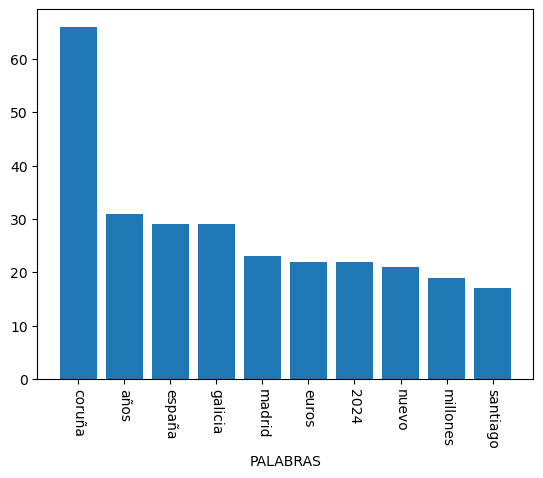

In [9]:
import pprint
import matplotlib.pyplot as plt
from pandas import DataFrame

diccionario_ordenado = sorted(frecuencias.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])
plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)

In [10]:
titularesOrdenados=sorted(datos,key= lambda x:x[2],reverse=True)

# Borramos si coincide titular
dicc = {}
for x in titularesOrdenados:
    dicc[x[0]] = x

titularesOrdenados = list(dicc.values())

**Librería para manejo de HTML**

In [11]:
#!conda install -y -c conda-forge airium
#!conda install -y pymysql

In [12]:
import time
from airium import Airium
from pymysql import Time

a = Airium()


a('<!DOCTYPE html>')
with a.html(lang="pl"):
    with a.head():
        a.meta(charset="utf-8")
        a.title(_t="Página de noticias")
    with a.body():
        for portada in titularesOrdenados:
            with a.p(style=f"font-size:{portada[2]+1}em;"):
                a(portada[0])

html = str(a)  # casting to string extracts the value
# or directly to UTF-8 encoded bytes:
html_bytes = bytes(a)  # casting to bytes is a shortcut to str(a).encode('utf-8')

with open(f"HTML/resultado-{time.localtime().tm_year}-{time.localtime().tm_mon}-{time.localtime().tm_mday}.html","w+") as f:
    f.write(html)


In [13]:
for i in titularesOrdenados[:20]:
    print(f"URL: {i[1]} - FRASE: {i[0]}")

URL: https://www.laopinioncoruna.es/coruna/2024/01/22/cerdopolis-existio-coruna-historia-97210816.html - FRASE: La "cerdópolis" que existió en A Coruña
URL: https://www.laopinioncoruna.es/coruna/2024/01/25/lobo-marino-playa-coruna-97349764.html - FRASE: ¿Cómo actuar si aparece de nuevo el lobo marino en A Coruña?
URL: https://www.laopinioncoruna.es/coruna/2024/01/26/viernes-26-enero-coruna-97368041.html - FRASE: ¿Qué hacer este viernes 26 de enero en A Coruña?
URL: https://www.laopinioncoruna.es/sociedad/2024/01/26/investigadores-coruna-coordinan-primer-mapa-97359631.html - FRASE: Investigadores de A Coruña coordinan el primer “mapa” de ‘superbacterias’ de España
URL: https://as.com/tenis/open_australia/medvedev-milagroso-tres-finales-en-cuatro-anos-n/ - FRASE: Medvedev, milagroso: tres finales en cuatro años
URL: https://www.laopinioncoruna.es/coruna/2024/01/22/baile-da-vida-97223481.html - FRASE: Un baile que “da la vida” en A Coruña
URL: https://www.elespanol.com/quincemil/articulos

In [14]:
#!conda install -y sqlite3

In [15]:
connection=None

In [16]:
import sqlite3

if not(connection):
    connection=sqlite3.connect("Media/titulares.db")

In [17]:
cursor = connection.cursor()
try:
    cursor.execute("CREATE TABLE titulares (titular TEXT,medio TEXT, url TEXT, prelativo REAL)")
except:
    print("La tabla ya está creada")

La tabla ya está creada


In [18]:
def buscador_titular_peso(URL):
    for i in datos:
        if i[1] == URL:
            return i[0],i[2]

In [19]:
valores = []
for key,values in claves.items():
    for url in values:
        titular,peso=buscador_titular_peso(url)
        valores.append([titular,key,url,peso])


cursor.executemany("""
    INSERT INTO titulares ('titular', 'medio', 'url', 'prelativo')
    VALUES (?,?,?,?)""", valores)

In [20]:
cursor.execute("SELECT * FROM titulares")

rows = cursor.fetchall()

rows

[('Alcoa reiniciará las cubas este próximo lunes, pero avisa que así los fondos se agotarán antes',
  'La voz de galicia',
  'http://www.lavozdegalicia.com/noticia/amarina/2024/01/26/alcoa-reiniciara-cubas-proximo-lunes-avisa-fondos-agotaran/00031706261849973822404.htm',
  0.12224264705882354),
 ('El juez García Castellón señala que Tsunami «tenía en mente» actuar contra la comitiva del rey en Barcelona en el 2020',
  'La voz de galicia',
  'http://www.lavozdegalicia.com/noticia/espana/2024/01/26/juez-garcia-castellon-senala-tsunami-tenia-mente-actuar-contra-comitiva-rey-visito-barcelona-2020/00031706267502538734394.htm',
  0.24019607843137258),
 ('Seis camiones que transportan palas eólicas, bloqueados en Pedrafita al no poder pasar por el viaducto de la A-6',
  'La voz de galicia',
  'http://www.lavozdegalicia.com/noticia/lugo/2024/01/26/seis-camiones-transportan-palas-eolicas-bloqueados-pedrafita-poder-pasar-viaducto-a-6/00031706265682442241796.htm',
  0.15712074303405574),
 ('El la

In [21]:
cursor.close()
connection.close()